# Some ECG signal data sets
MIT-BIH cardiac arrythmia dataset to get started.
https://www.physionet.org/content/mitdb/1.0.0/

The signals were digitized @ 360 samples per second 11-bit resolution over a 10 mV range.

MIT-BIH Atrial Fibrilation data set
https://physionet.org/content/afdb/1.0.0/#files-panel

qtdb ecg database
https://physionet.org/content/qtdb/1.0.0/

This thing is becoming an annotation tool for a text + image + signals model.

Things implemented
1. signal reader
2. RR interval estimator
3. Prompt generation --> take the RR interval, and annotation data and append it to the end of a personality statement for the model.
4. Text Generation using a pretrained model (GPT2) available on HuggingFace

Need to implement
1. QT interval estimator
2. State machine for P, QRS, or T wave. or something to segment this
3. Something to detect the switch to AFIB -- or predict likelihood of AFIB occuring.
4. plt.savefig() to pass images along with the prompt.

In [17]:
# this gives access to your whole drive and google account
# dont put anything in here that youre not using to code
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
# wfdb stands for waveform database - use it for reading physiological signals
# documentation is available @ https://wfdb.readthedocs.io/en/latest/wfdb.html
!pip install wfdb

In [19]:
# do the imports
import os
import glob
import wfdb
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal as scisig
from scipy.signal import medfilt


Number of files  12
signal shape  (650000, 2)
field keys  dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments'])
signal array  [[-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.375]
 [-0.14  -0.35 ]
 [-0.115 -0.355]]
fields dictionary  {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The episodes of paroxysmal atrial flutter/fibrillation are usually', 'followed by nodal escape beats.  There are several intervals of', 'high-frequency noise/artifact in both channels.']}


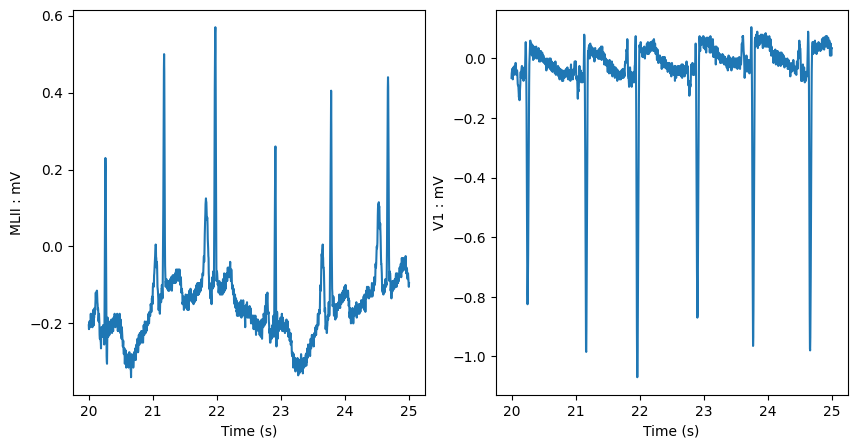

In [20]:
def Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320):
  T2 = t_win + T1
  time_ = np.linspace(T1,T2, t_win*fs)

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(time_, signals[T1*fs:T2*fs,i])
    axes[i].set_xlabel('Time (s)')
    # so signame here is the lead -- the view across the heart that this signal
    # gives us.
    axes[i].set_ylabel(fields['sig_name'][i] + ' : '+fields['units'][i])

def MIT_BIH_reader(SigNumber = -3):
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))


  # wfdb get signals
  signals, fields = wfdb.rdsamp(hea[SigNumber], )
  # print(type(signals))
  # print(type(fields))

  # signals is a numpy array, and fields is a dict
  print('signal shape ', signals.shape)
  print('field keys ', fields.keys())

  # print the array real quick
  print('signal array ', signals[0:10,:]) # signal
  print('fields dictionary ', fields) # notes about the signals

  # Note that the signals were digitized @ 360 samples per second
  # 11-bit resolution over a 10 mV range. so if you want
  fs = fields['fs'] # sampling frequency - should be 360

  # signal is already in milivolts ok.
  # plotting

  Plot_signals(signals, fields, T1 = 20, t_win = 5, fs= 320)
  return signals, fields


signals_, fields_ = MIT_BIH_reader(SigNumber = -3)


In [21]:
# want to know which files ha
def function2():
  # first pass
  hdir = '/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/'
  # get all the file names from the data set
  hea = sorted(glob.glob(os.path.join(hdir,'*.hea')))
  hea = [hh.replace('.hea','') for hh in hea]

  # wfdb does not need the extension - it figures all that out apparently
  print('Number of files ', len(hea))

  for SigNumber in range(len(hea)):
    print(hea[SigNumber])
    # wfdb get signals
    signals, fields = wfdb.rdsamp(hea[SigNumber], )
    print(fields)
function2()

Number of files  12
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/100
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/101
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V1'], 'comments': ['75 F 1011 654 x1', 'Diapres']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/103
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V2'], 'comments': ['-1 M 742 654 x1', 'Diapres, Xyloprim']}
/content/drive/My Drive/PublicHeartDatasets/mit-bih-arrhythmia-database-p-wave-annotations-1.0.0/106
{'fs': 360, 'sig_len': 650


---
Now we have something that can just open signal files. we probably want some denoising stuff first. Then we can start setting windows around the different peaks. -- Peak detection with old fashioned AI approahces.  

---



In [22]:
plt.close('all')

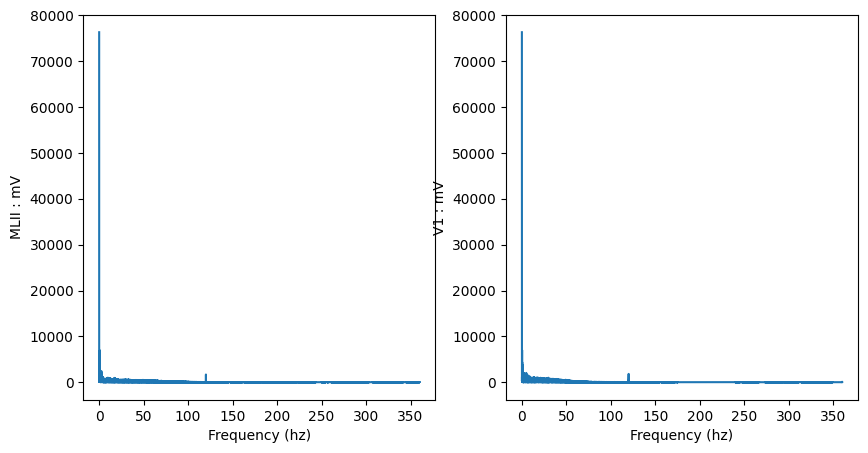

In [23]:
# signal to noise estimate right.
def MagSpectPlotter(signals_, fields_):
  signals_ = signals_ - np.mean(signals_)
  samps = int(signals_.shape[0]/2)

  spect = np.fft.fft(signals_, axis = 0,) # fast fourier transform
  mag = np.abs(spect) # magnitude at each frequency
  freqs = np.linspace(0, fields_['fs'], samps) # frequency axis

  fig, axes = plt.subplots(1,2, figsize=(10, 5))
  for i in range(2):
    axes[i].plot(freqs, mag[0:samps, i])
    axes[i].set_xlabel('Frequency (hz)')
    # # so signame here is the lead -- the view across the heart that this signal
    # # gives us.
    axes[i].set_ylabel(fields_['sig_name'][i] + ' : '+fields_['units'][i])

  plt.show()

MagSpectPlotter(signals_, fields_)

working 


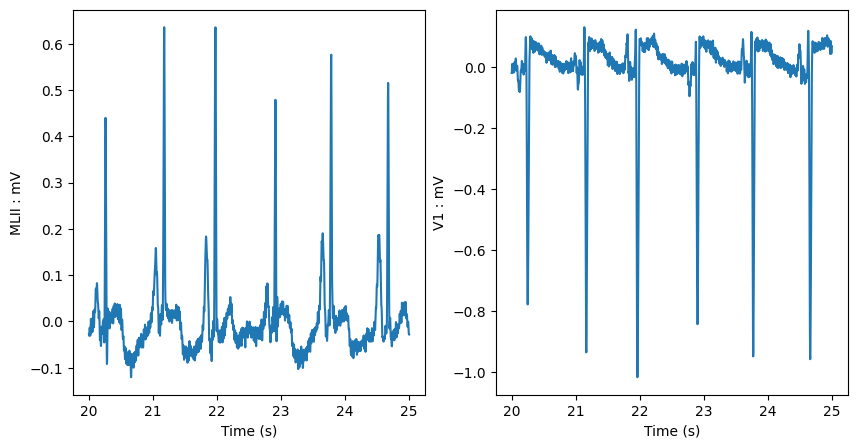

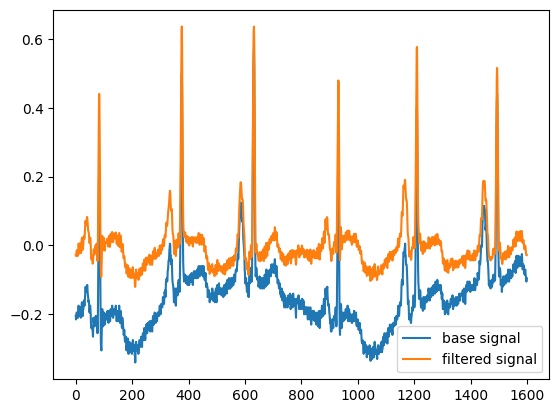

In [24]:
# program signal denoising and interval detectors here.
def NoiseReduction(signals_, fields_, T1 = 1, t_win = 5, fs= 320):
    fs = 0+fields_['fs']
    T2 = t_win + T1
    time_ = np.linspace(T1,T2, t_win*fs)
    print('working ')
    # parameters for initial band pass filtering
    cut_args={
              'smp_rate' : fs, # sampling rate
              'lp_pass' : 80, # low pass filter pass band
              'lp_stop' : 90, # low pas filter stop band
              'hp_pass' : 0.75, # high pass filter pass band
              'hp_stop' : 0.01, # high pass filter stop band
              'sb_att' : 210, # stop band attenuation
             }
    # leaving filter design components in place
    nyq_rate = cut_args['smp_rate']/2
    lbord,lwn = scisig.cheb2ord(wp = cut_args['lp_pass']/nyq_rate, ws =cut_args['lp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])
    # High pass filter stop at 0.1Hz, and pass at 1Hz
    hbord,hwn = scisig.cheb2ord(wp = cut_args['hp_pass']/nyq_rate, ws = cut_args['hp_stop']/nyq_rate, gpass = .1, gstop = cut_args['sb_att'])

    lb,la = scisig.cheby2(N = lbord, rs = cut_args['sb_att'], Wn = lwn,
                          btype = 'lowpass', output ='ba')

    hb,ha = scisig.cheby2(N = hbord, rs = cut_args['sb_att'], Wn = hwn,
                          btype = 'highpass', output ='ba')

    # right now we only get one signals
    fdat = scisig.filtfilt(lb, la, signals_, axis = 0)
    fdat = scisig.filtfilt(hb, ha, fdat, axis = 0)

    # plt.figure(figsize=(10, 5))

    # plt.plot(time_, signals_[fs*T1:fs*T2,0], label = 'base signal')
    # plt.plot(time_, fdat[fs*T1:fs*T2], label = 'cleaner signal')
    # plt.legend()
    # plt.show()
    return fdat

# now just rewrite this to dump the cleaner signal
filtered_data = NoiseReduction(signals_, fields_, T1 = 20)
Plot_signals(filtered_data, fields_, T1 = 20, t_win = 5, fs= 320)

plt.figure()
plt.plot(signals_[20*320:25*320,0], label = 'base signal')
plt.plot(filtered_data[20*320:25*320,0], label = 'filtered signal')
plt.legend()
plt.show()


# median filter and call it to get rid of the little noise peaks

In [25]:
plt.close('all')

(650000, 2)
mean signal :  -0.0011019448546201883
RMS signal:  0.12200503772223822
R-R Intervals :  [[0.8125  0.98125 1.025   0.99375]]
Average R-R Interval :  0.9531249999999999
Std R-R Interval :  0.08273876434296076


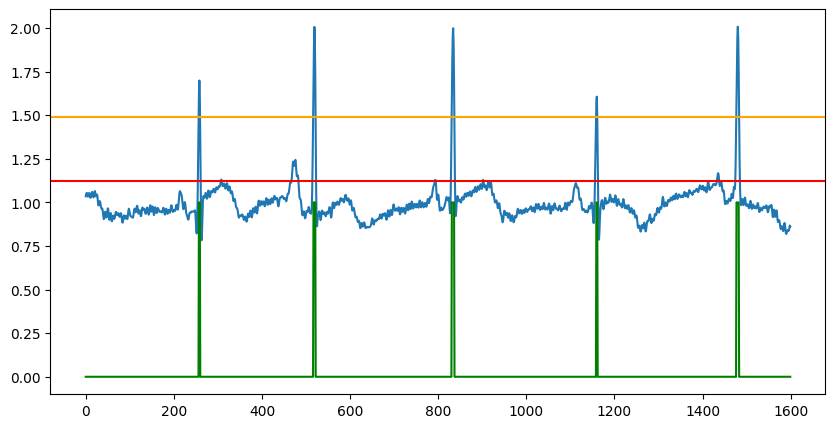

In [26]:
# put this into a function....
# savitzky-Golay filter is a moving average filter that has a polynomial
# approximation of the data. so it's good for smoothing. - data, window, polynomial
# smoothed_fdata = sp.signal.savgol_filter(filtered_data[0:320*5, 0],7,2,)

# so RMS threshold will pretty much reliably give you the P and R waves
def GetRRInterval(x, T0 = 0, T = 5, fs = 320, th = 3 ):
    # Easy but breakable version of this is to threshold wrt the rms signal
    win_filtered_data = x[T0*fs:T*fs]
    # # some signals have inverted QRS, so I want to flip it if thats the case
    # # R is a big peak so it'll weight the rest of the signal more negative
    mean_sig = np.mean(win_filtered_data)
    # if mean_sig <0 :
    #   win_filtered_data = -1*win_filtered_data

    rms = np.sqrt(np.mean(np.square(win_filtered_data)))
    print('mean signal : ', mean_sig)
    print('RMS signal: ', rms)

    # threshold
    R_waves = (win_filtered_data > th*rms) +0

    # then you can take diff of R waves to get the left edge..
    left_edge = np.diff(R_waves) > 0

    # divide by 320 to get time in seconds.
    RR_intervals = np.diff(np.where((left_edge)+0 ==1)) /320

    print('R-R Intervals : ', RR_intervals)
    print('Average R-R Interval : ', np.mean(RR_intervals))
    print('Std R-R Interval : ', np.std(RR_intervals))

    # return an output dictionary so the number of outputs isnt so long
    output_object = {
        'win_filtered_data' : win_filtered_data,
        'RR_intervals' : RR_intervals,
        'R_waves' : R_waves,
        'rms' : rms,
        'th' : th,
        'T0':T0,
        'T':T,
    }
    return output_object

print(filtered_data.shape)
outputs = GetRRInterval(filtered_data[:,0], T0=115, T=120, th = 4)

# Ploting
plt.figure(figsize=(10,5))
plt.plot(outputs['win_filtered_data'] + 1)
plt.axhline(outputs['rms'] + 1, color = 'red')
plt.axhline(outputs['th']*outputs['rms'] + 1, color = 'orange')
plt.plot(outputs['R_waves'], 'g')


Once you get the R wave, you can make a window around the R wave find the max values- so the one on the left will be the P peak, and the one on the right will be the T peak. Compute intervals that way. Now in a real time situation you would not do this. you only assume you have past and present data. never future data. For this purpose you can assume the sensor is storing memory and making a desicion after the buffer is full since it is not a real time detection system.

So now we have the R-R Interval. We can get average R-R Interval, and standard deviation for that window. We have a measure of heart rate variability. It's not *the measure of* heart rate variability but still related to it.

mean signal :  0.06196832434604691
RMS signal:  0.12765671274270132
R-R Intervals :  [[0.815625 0.98125  1.01875  1.003125]]
Average R-R Interval :  0.9546874999999999
Std R-R Interval :  0.08138510401940886


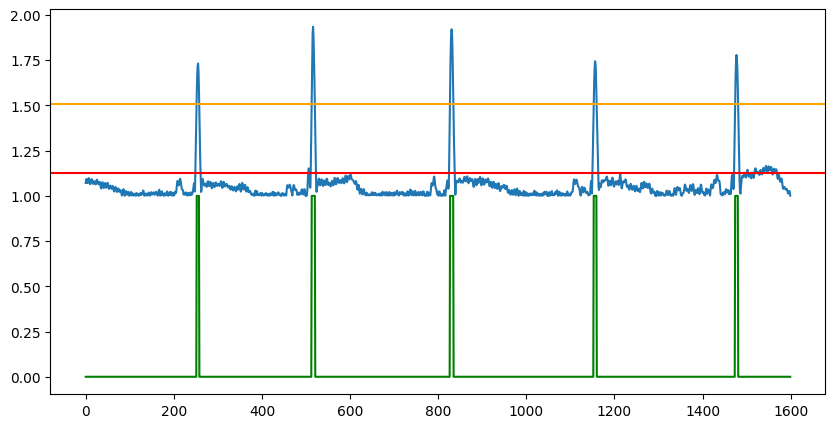

In [27]:
# the other veiw has an inverted QRS - so take absolute value to get it to work.
outputs_1 = GetRRInterval(np.abs(filtered_data[:,1]), T0=115, T=120, th = 4)
plt.figure(figsize = (10,5))
plt.plot(outputs_1['win_filtered_data'] + 1)
plt.axhline(outputs_1['rms'] + 1, color = 'red')
plt.axhline(outputs_1['th']*outputs_1['rms'] + 1, color = 'orange')

plt.plot(outputs_1['R_waves'], 'g')

In [28]:
plt.close('all')

In [29]:
# reviewing what is available in the patient metadata
for k,v in fields_.items():
  print(k,v)

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['MLII', 'V1']
comments ['84 F 1633 1629 x1', 'Digoxin, Quinidine', 'The episodes of paroxysmal atrial flutter/fibrillation are usually', 'followed by nodal escape beats.  There are several intervals of', 'high-frequency noise/artifact in both channels.']


# Programatically generating prompts
Extract some information from the signals; in this case we have the R-R intervals. Format the text so that the prompt has a bit of context for the model. In this case we want to tell the model it is a cardiologist. Then add on the formated text that has the inforamtion we pulled from the annotations and ECG signal . Then in the last part of the prompt we ask the model to do some tasks.

In [30]:
def TextInputOrganizer(fields_, outputs, view = ''):
  # Age, Sex, number, number, xnumber
  patient_generals = fields_['comments'][0].split(' ')
  text_ = f'Age : {patient_generals[0]}\n'
  text_ += f'Gender : {patient_generals[1]}\n'
  text_+= f'ECG window {outputs["T"] - outputs["T0"]}s\n'
  text_+= f'RR-intervals: {outputs["RR_intervals"]}\n'
  text_ += f'Average RR-Interval : {np.mean(outputs["RR_intervals"]):.2f}\n'
  text_+= f'Standard Deviation in RR-Interval : {np.std(outputs["RR_intervals"]):.2f}\n'
  text_+=f'View : {view}\n'
  # list of medications
  text_+=f'Medications : {fields_['comments'][1]}\n'

  return text_

text_out = TextInputOrganizer(fields_, outputs, view = 'MLII')
print(text_out)

# Give the model a persona
context = 'You are a cardiologist monitoring a patient who has had '
context += 'arrhythmias in the past.\n You see the following information in '
context += 'the patients ECG record and history : \n'

# add in the information extracted from the ECG signal and the patient annotation
context += text_out

# Questions of interest
tasks = [
          'Does this patient need additional medication?',
          'Should you continue monitoring the ECG signal?',
          'What should you do next?',
          'Describe the ECG rhythm.']

prompts = [context+task for task in tasks]

for p in prompts :
  print(p)
  print('---')

Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine

You are a cardiologist monitoring a patient who has had arrhythmias in the past.
 You see the following information in the patients ECG record and history : 
Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine
Does this patient need additional medication?
---
You are a cardiologist monitoring a patient who has had arrhythmias in the past.
 You see the following information in the patients ECG record and history : 
Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine
Should you continue monitoring the ECG sig

In [15]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
Device set to use cpu


In [16]:
# this part generates the text given the prompt you pass in.
for prompt_ in prompts:
  print('--------')
  # I accidentally passed the model the letter Y like 3 times and you get interesting outputs
  gpt2_outputs = generator(prompt_, max_new_tokens = 128, num_return_sequences=1)
  print(gpt2_outputs[0]['generated_text'])
# print(gpt2_sequences['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a cardiologist monitoring a patient who has had arrhythmias in the past.
 You see the following information in the patients ECG record and history : 
Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine
Does this patient need additional medication?
No.
No.
No.
Yes, this patient needs additional treatment.
If it's a complication of the treatment, the patient may need additional medication.
This is an indication of how important this is to a physician.
This is an indication of how important this is to a physician.
This is an indication of how important this is to a physician.
This is an indication of how important this is to a physician.
This is an indication of how important this is to a physician.
This is an indication of how important this is to a physician.
This is an indication of how important this
--------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a cardiologist monitoring a patient who has had arrhythmias in the past.
 You see the following information in the patients ECG record and history : 
Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine
Should you continue monitoring the ECG signal?
If the ECG is not responding to the medication, you should monitor the ECG. If the ECG is responding to the medication, then you need to monitor the ECG. This is done by monitoring the ECG with a magnetic strip. If the ECG is not responding to the medication, then you should monitor the ECG. This is done by monitoring the ECG with a magnetic strip.
This is a simple chart to take to check your ECG sensitivity and keep track of your medication. It is based on the Patient Advocate Patient Register (PAP) and is available from the FDA website.
Cancer
--------


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a cardiologist monitoring a patient who has had arrhythmias in the past.
 You see the following information in the patients ECG record and history : 
Age : 84
Gender : F
ECG window 5s
RR-intervals: [[0.8125  0.98125 1.025   0.99375]]
Average RR-Interval : 0.95
Standard Deviation in RR-Interval : 0.08
View : MLII
Medications : Digoxin, Quinidine
What should you do next?
If an overdose is suspected, check with your GP. Consult your primary care doctor for details.
Why is the emergency room treating an overdose?
The emergency room is a common place for overdose treatment. In some cases, an overdose in a emergency room can be prevented by a doctor's intervention. This is often done in a hospital, by calling 999 or calling the local ambulance service.
You can also call the emergency department if you're feeling dizzy, cold or having a headache.
Why aren't there more emergency departments?
There's usually more out there. These emergency departments are usually staffed by emergency nu

# The need for fine tuning models
Clearly the model output above is not reliable at best. But ok now we have the main parts of our system. And we have a way to test which questions we can pass to the model.

# Asking ChatGPT5 about medications that patients were on in the study
What effects would we think Pronestyl would have on the heart?
---

ChatGPT5 responds with

---

Pronestyl is the brand name for procainamide, a Class Ia antiarrhythmic drug. Its main effects on the heart come from how it alters ion flow across cardiac cells:

Mechanism of Action

* Blocks fast sodium channels → slows depolarization in cardiac myocytes, which reduces conduction velocity.

* Prolongs action potential duration by also blocking some potassium channels → lengthens the refractory period.

* These actions reduce the ability of abnormal electrical circuits to sustain arrhythmias.

Expected Cardiac Effects

* Slows conduction through the atria, ventricles, and His-Purkinje system.

* Suppresses abnormal automaticity (ectopic pacemaker activity).

* Prolongs the QT interval on ECG because of delayed repolarization.

* Treats ventricular and supraventricular arrhythmias, including atrial fibrillation, atrial flutter, and ventricular tachycardia.

Potential Adverse Effects

* Arrhythmogenic risk: QT prolongation can lead to torsades de pointes.

* Negative inotropy: can decrease contractility, especially in compromised hearts.

* Hypotension: more common with IV use due to vasodilation.

* Long-term use: can cause a lupus-like syndrome.

👉 In short: Pronestyl slows conduction, prolongs refractory periods, and can help stop arrhythmias—but it carries risks of QT prolongation and reduced pumping strength.

Would you like me to sketch out how this would look on an ECG before vs. after Pronestyl (e.g., widened QRS, prolonged QT)?


# Some other prompts to programatically ask of text models
What you want to get out of this prompt is a numercial measure you can use to supplement the Arrhythmia detector with down the line.

## A. General effects
What effects on the heart would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## B. A + include ECG view
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual?

## C. B + include arrythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact an algorithm that does arrhythmia detection?

## D. C + include methodology for arrhythmia detection
What effects on the *[view]* ECG signal would we think *[drug]* would have on the heart in a *[age]* *[gender]* individual? How would this impact the R-R interval portion of an algorithm that detects arrhythmias?



Think about using this model for the visual question answering task.
https://huggingface.co/google/pix2struct-chartqa-base



